**Table of contents**<a id='toc0_'></a>    
- 1. [Correlation distance in Cascadia     ](#toc1_)    
- 2. [Load data    ](#toc2_)    
- 3. [Compute correlation distance matrix   ](#toc3_)    
- 4. [Measuring periodicity in space](#toc4_)    
- 5. [Plot for the paper  ](#toc5_)    
  - 5.1. [Results](#toc5_1_)    
  - 5.2. [Methods](#toc5_2_)    
  - 5.3. [For the supplements ](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Correlation distance in Cascadia      [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as path_effects
import matplotlib.patheffects as fx


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [2]:
mag_min = 2.2

# 2. <a id='toc2_'></a>Load data     [&#128285;](#toc0_)
Directly from pre-processed catalogs — with earthquake counts and modeled depths.

In [3]:
day0 = pd.Timestamp('2009-08-01')

In [4]:
# Load tremor
trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_trim_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

In [5]:
# Load earthquakes
eq = pd.read_csv('data/cascadia/processed/casc_eqmc{:.1f}_0809_0624_trim_eqdist.csv'.format(mag_min))

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


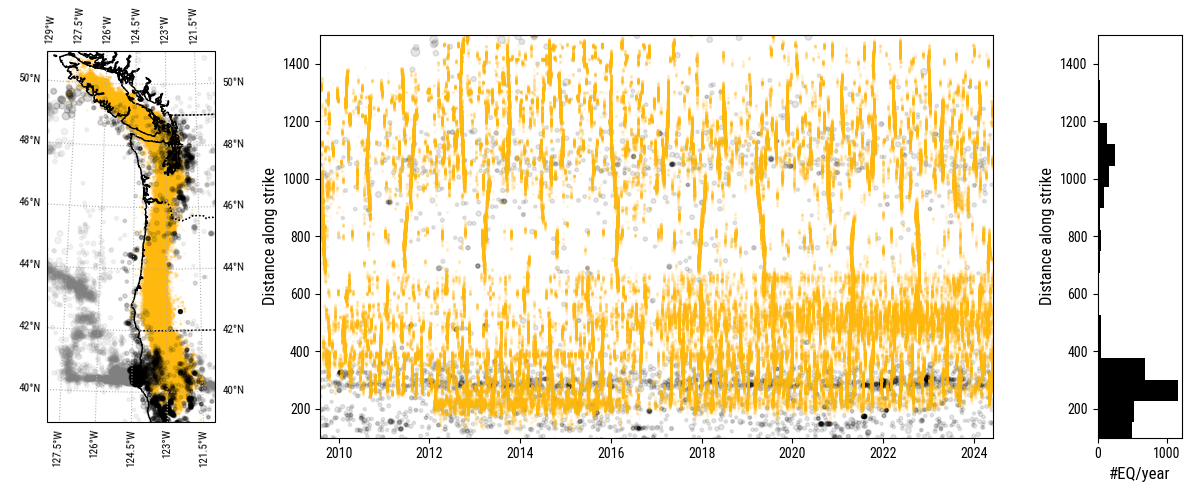

In [6]:
# Overview
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 1])

# Map
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

ax = fig.add_subplot(gs[0], projection=crs)
min_lon, max_lon = -128, -121
min_lat, max_lat = 39, 51
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, color='.7', zorder=0)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=1)
gl = ax.gridlines(draw_labels=True, ls=':', zorder=-1)
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

ax.scatter(trm.lon, trm.lat, s=1, c=[to_rgba('C2', .1) for ii in range(len(trm))], transform=ccrs.PlateCarree())
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, c=[to_rgba('.5', .1) for ii in range(len(eq))], transform=ccrs.PlateCarree(), zorder=-1)
ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], s=eq.mag[eq.in50km]**2, c=[to_rgba('k', .1) for ii in range(len(eq[eq.in50km]))], transform=ccrs.PlateCarree(), zorder=1)

# Time-strike
ax = fig.add_subplot(gs[1])
ax.set_ylabel('Distance along strike')
ax.set_xlim(trm.date.min(), trm.date.max())
ax.set_ylim(100, 1500)

ax.plot(trm.date, trm.xf, ls='', marker='o', mfc=to_rgba('C2', .1), mec=[0,0,0,0], ms=2)
indicator = eq.in50km & (eq.mag > 2)
ax.scatter(eq.date[indicator], eq.xf[indicator], c=[to_rgba('k', .1) for ii in range(indicator.sum())], s=eq.mag[indicator]**2, zorder=1)

# --> Find where longitudes are along strike
# coords = ccrs.PlateCarree().transform_points(crs, eq.x[0]*1000, eq.y[0]*1000)
# lon = coords[:, 0]
# lat = coords[:, 1]

# coords = ccrs.PlateCarree().transform_points(crs, np.array(X)*1000, np.array(Y)*1000)
# lon = coords[:, 0]
# lat = coords[:, 1]

# lats = np.array([40, 42, 44, 46, 48, 50])

# ilats = np.abs(lat[:, np.newaxis] - lats).argmin(axis=0)
# lats_along_strike = S[ilats]

# ax_lats = ax.twinx()
# ax_lats.set_ylim(ax.get_ylim())
# ax_lats.set_yticks(lats_along_strike)
# ax_lats.set_yticklabels([f'{lat:.0f}°N' for lat in lats])

# Earthquake activity
ax = fig.add_subplot(gs[2], sharey=ax)
ax.set_xlabel('#EQ/year')
ax.set_ylabel('Distance along strike')
ax.hist(eq.xf[eq.in50km], bins=20, orientation='horizontal', color='k')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute correlation distance matrix    [&#128285;](#toc0_)

In [48]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 200
xmax_bin = 1400
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

print('Parameters:\n - dx_bin = {:.0f} km\n  - delta = {:.0f} days\n  - norm = {}\n  - no_bias = {}\n  - look_both_ways = {}\n  - v_min = {:.1f} km/day'.format(dx_bin, delta, norm, no_bias, look_both_ways, v_min))

Parameters:
 - dx_bin = 10 km
  - delta = 1 days
  - norm = True
  - no_bias = True
  - look_both_ways = True
  - v_min = 3.5 km/day


In [49]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
# start_day = trm.day[trm.date > np.datetime64('2012-01-01')].min()
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    print('{:d}/{:d}'.format(ii, len(x_bin_edges)-1), end='\r')
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

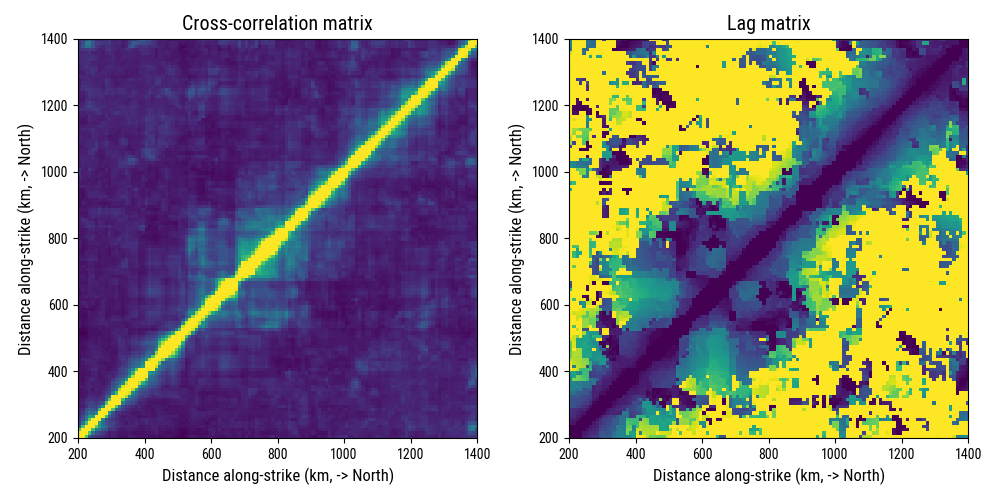

In [50]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

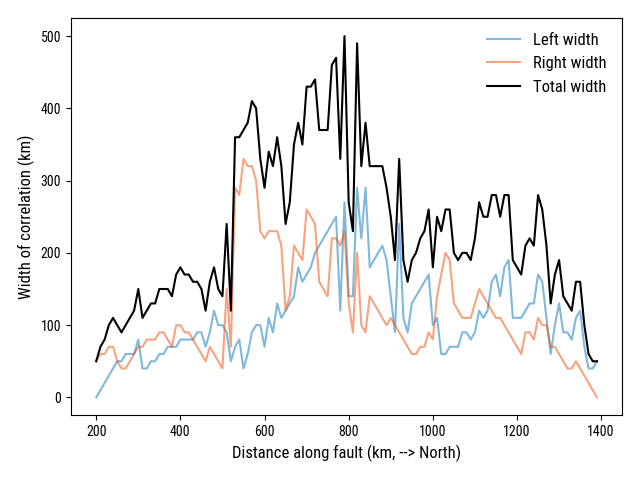

In [51]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

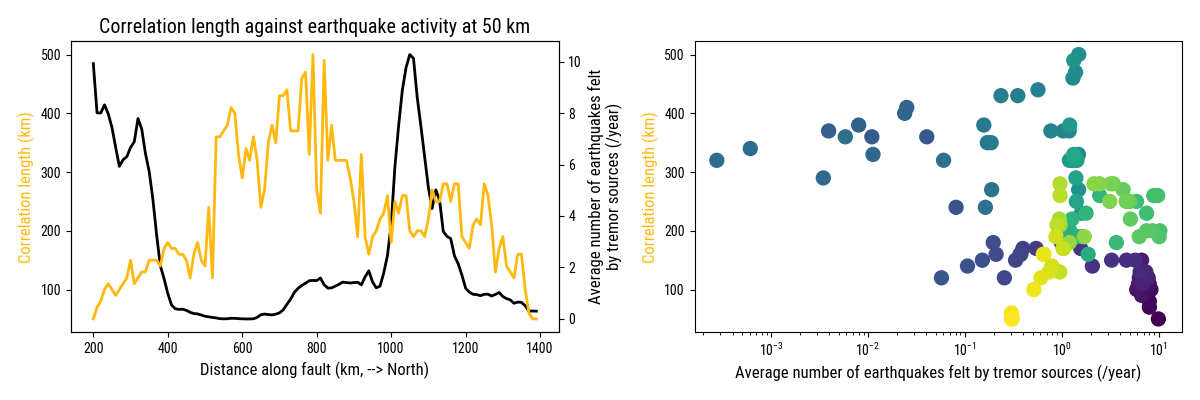

In [52]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 50
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
# ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.scatter(n_close_eq[chosen_dist], corr_length, c=x_bin_edges[:-1], cmap='viridis', s=100)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [53]:
# Stats
from scipy.stats import linregress
n_eq = np.log10(n_close_eq[chosen_dist])
cc_d = corr_length

slope, intercept, r_value, p_value, std_err = linregress(n_eq, cc_d)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((cc_d - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((cc_d - np.mean(cc_d))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:-45.12
Error on slope (std): ±10.07
Corellation coefficient:-0.38
Percentage of variance explained (R²): 14.5%


In [54]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta}

path = 'results/casc_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print(f'Saving results to {path}')
    pickle.dump(results, f)

Saving results to results/casc_synch_mc2.2_dx10_cc0.07.pkl


# 4. <a id='toc4_'></a>Measuring periodicity in space [&#128285;](#toc0_)


In [55]:
# import scipy.io as sio
# sio.savemat('/Users/gaspard/Desktop/cascadia_full_results_2012_2024_dx10km.mat', mdict={'counts': counts, 'corr_length': corr_length, 'n_eq_50km': n_close_eq[50]})  

Average DT = 253.3 days
Std DT = 149.2 days
Coeff of variation: 0.59


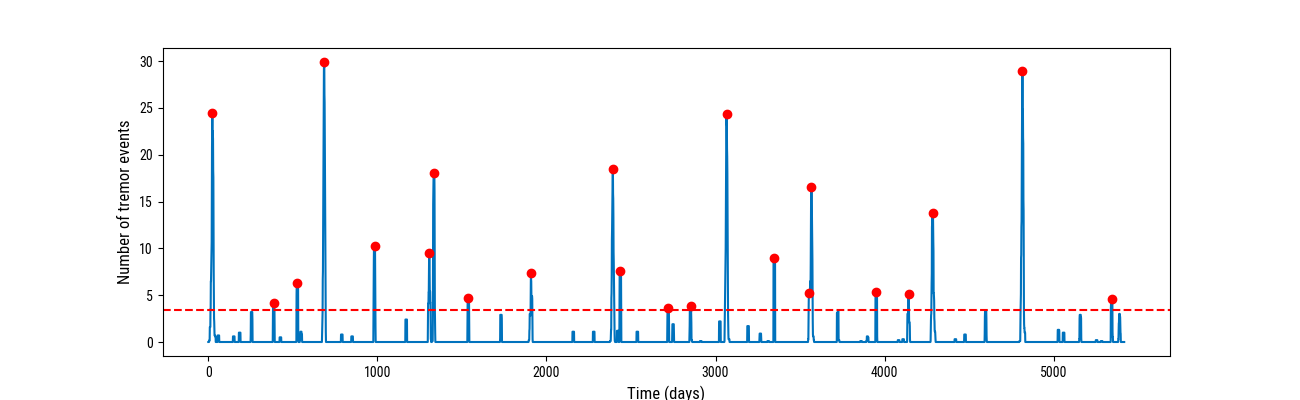

In [56]:
# For 1 count
count = counts[60]

smooth_count = np.convolve(count, np.ones(10)/10, mode='same')
threshold = np.percentile(smooth_count, 95)

from scipy.signal import find_peaks
peaks, _ = find_peaks(smooth_count, height=threshold, distance=10)

print('Average DT = {:.1f} days'.format(np.mean(np.diff(count_time[peaks]))))
print('Std DT = {:.1f} days'.format(np.std(np.diff(count_time[peaks]))))
print('Coeff of variation: {:.2f}'.format(np.std(np.diff(count_time[peaks])) / np.mean(np.diff(count_time[peaks]))))

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(count_time[:-1], smooth_count)
ax.plot(count_time[peaks], smooth_count[peaks], 'o', color='r')
ax.axhline(threshold, color='r', ls='--')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of tremor events')
plt.show()

In [57]:
# For all counts
from scipy.signal import find_peaks
dTs = []

threshold = np.percentile(counts, 95)
print('Peak = more than {:.0f} events in a day'.format(threshold))

for count in counts:
    if count.sum() == 0:
        dTs.append([])
    else:
        peaks, _ = find_peaks(count, height=threshold, distance=10)
        dT = np.diff(count_time[peaks])
        dTs.append(dT)

# mean where there are values, 0 if not
mean_dT = np.array([np.mean(dT) if len(dT) else 0 for dT in dTs])
median_dT = np.array([np.median(dT) if len(dT) else 0 for dT in dTs])
dT_80 = np.array([np.percentile(dT, 80) if len(dT) else 0 for dT in dTs])
std_dT = np.array([np.std(dT) if len(dT) else 0 for dT in dTs])
import scipy.stats
kurt_dT = np.array([scipy.stats.kurtosis(dT) if len(dT) else 0 for dT in dTs])

Peak = more than 2 events in a day


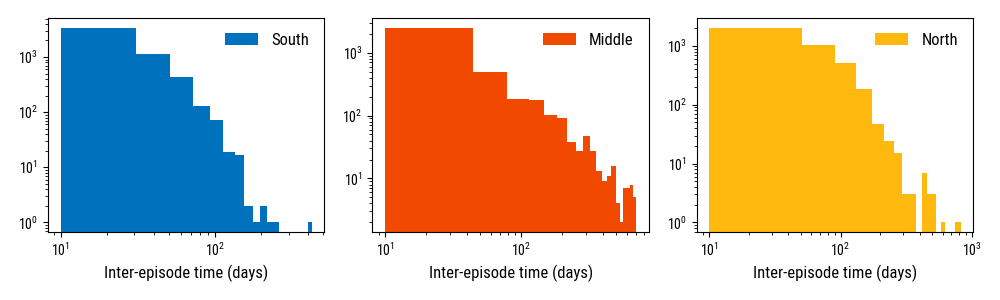

In [58]:
# Distribution of dTs
south = (x_bin_edges[:-1] < 500)
middle = (x_bin_edges[:-1] >= 500) & (x_bin_edges[:-1] < 950)
north = (x_bin_edges[:-1] >= 950)

dTs_south = np.concatenate([dT for dT, s in zip(dTs, south) if s])
dTs_middle = np.concatenate([dT for dT, m in zip(dTs, middle) if m])
dTs_north = np.concatenate([dT for dT, n in zip(dTs, north) if n])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(dTs_south, bins=20, color='C0', lw=2, label='South')
ax[1].hist(dTs_middle, bins=20, color='C1', lw=2, label='Middle')
ax[2].hist(dTs_north, bins=20, color='C2', lw=2, label='North')

for a in ax:
    a.set_yscale('log')
    a.set_xscale('log')

for a in ax:
    a.set_xlabel('Inter-episode time (days)')
    a.legend()
plt.tight_layout()
plt.show()

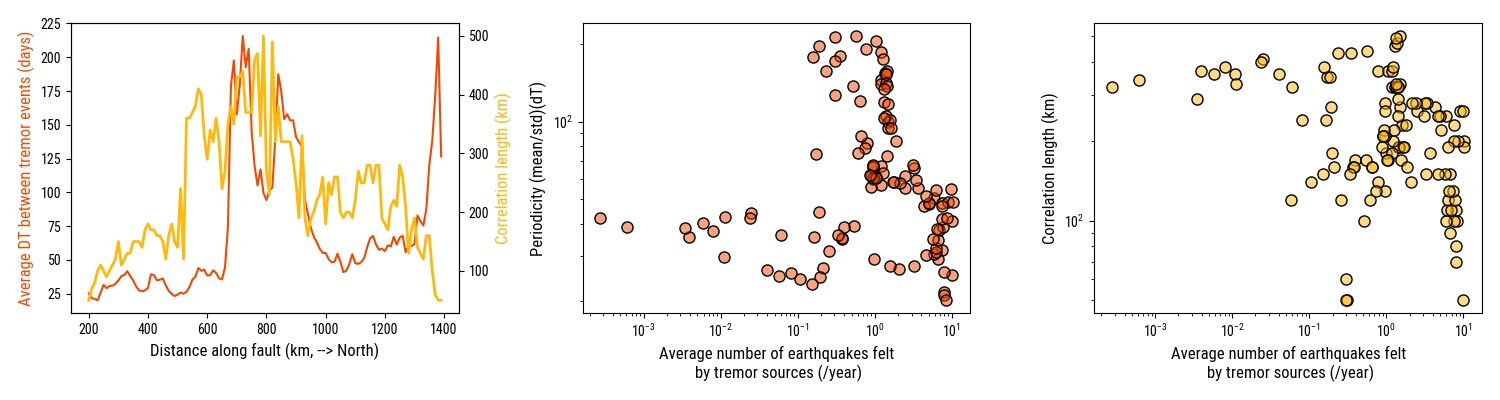

In [59]:
# Results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(x_bin_edges[:-1], mean_dT, color='C1', label='periodicity (mean/std)(dT)')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Average DT between tremor events (days)', c='C1')

ax_ = ax.twinx()
ax_.set_ylabel('Correlation length (km)', color='C2')
ax_.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2, label='Correlation length')

ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt\n by tremor sources (/year)')
ax.set_ylabel('Periodicity (mean/std)(dT)')
ax.plot(n_close_eq[chosen_dist], mean_dT, 'o', label='periodicity (mean/std)(dT)', ms=8, mec='k', mfc=to_rgba('C1', .5))

ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', label='Correlation length', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_ylabel('Correlation length (km)')
ax.set_xlabel('Average number of earthquakes felt\n by tremor sources (/year)')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# 5. <a id='toc5_'></a>Plot for the paper   [&#128285;](#toc0_)

## 5.1. <a id='toc5_1_'></a>Results [&#128285;](#toc0_)

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


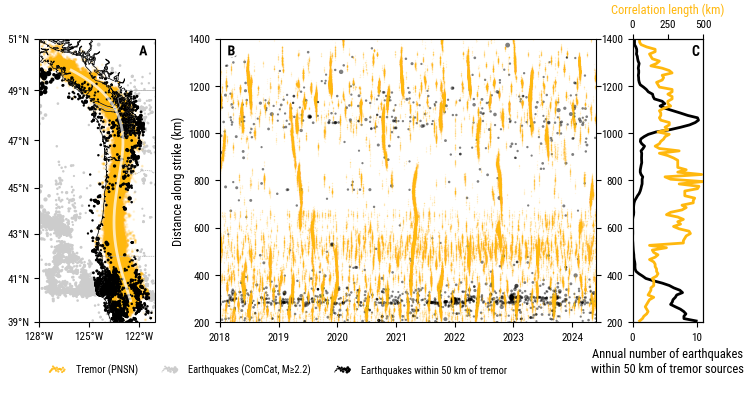

In [67]:
# Plot for paper
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 10])/2.54)
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 1.5])
    fig.set_facecolor('.95')

    # Map
    # crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())
    crs = ccrs.Mercator()

    # ax = fig.add_subplot(gs[0], projection=crs)
    aspect_ratio = 12.7/5.3
    top = .9
    left = -.02
    width = .3
    height = width * aspect_ratio
    x0, y0 = left, top - height
    ax = plt.axes([x0, y0, width, height], projection=crs)

    min_lon, max_lon = -128, -121
    min_lat, max_lat = 39, 51
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5, zorder=12)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=.5, color='.7', zorder=10)
    ax.add_feature(cfeature.STATES, linestyle=':', linewidth=.5, edgecolor='.7', zorder=11)

    ax.set_xticks(np.arange(min_lon, max_lon, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat, max_lat+2, 2), crs=ccrs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.scatter(trm.lon, trm.lat, s=1, c=[to_rgba('C2', .1) for ii in range(len(trm))], transform=ccrs.PlateCarree(), rasterized=True)
    ax.scatter([], [], s=1, c=to_rgba('C2', 1), transform=ccrs.PlateCarree(), rasterized=True, label='Tremor (PNSN)')  # for the legend

    ax.scatter(eq.lon, eq.lat, s=eq.mag**2/2, c=[to_rgba('.8', 1) for ii in range(len(eq))], transform=ccrs.PlateCarree(), edgecolor=[0,0,0,0], zorder=-1, rasterized=True, label='Earthquakes (ComCat, M≥2.2)')
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], s=eq.mag[eq.in50km]**2/2, c=[to_rgba('k', 1) for ii in range(len(eq[eq.in50km]))], transform=ccrs.PlateCarree(), edgecolor=[0,0,0,0], zorder=1, rasterized=True, label='Earthquakes within 50 km of tremor')

    along_strike = pickle.load(open('data/cascadia/processed/along_strike.pkl', 'rb'))
    along_strike_lon = along_strike['lon'][(along_strike['s'] > 200) & (along_strike['s'] < 1400)]
    along_strike_lat = along_strike['lat'][(along_strike['s'] > 200) & (along_strike['s'] < 1400)]
    
    ax.plot(along_strike_lon, along_strike_lat, ls='-', lw=2, color=to_rgba('w', .7), transform=ccrs.PlateCarree(), zorder=13)

    ax.text(.93, .98, 'A', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right', path_effects=[path_effects.withStroke(linewidth=3, foreground='w')])

    # Time-strike
    ax = fig.add_subplot(gs[1])
    ax.set_ylabel('Distance along strike (km)', labelpad=2)
    ax.tick_params(right=True)
    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2024-06-01'))
    ax.set_ylim(200, 1400)

    ax.plot(trm.date[(trm.date > np.datetime64('2018-01-01')) & (trm.date < np.datetime64('2024-06-01'))], trm.xf[(trm.date > np.datetime64('2018-01-01')) & (trm.date < np.datetime64('2024-06-01'))], ls='', marker='o', mfc=to_rgba('C2', .1), mec=[0,0,0,0], ms=1, rasterized=True)
    indicator = eq.in50km & (eq.mag > mag_min)
    ax.scatter(eq.date[indicator], eq.xf[indicator], c=[to_rgba('k', .5) for ii in range(indicator.sum())], s=eq.mag[indicator]**2 / 2, zorder=1, edgecolor=[0,0,0,0], rasterized=True)

    ax.text(.02, .98, 'B', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left', path_effects=[path_effects.withStroke(linewidth=3, foreground='w')])

    # Earthquake activity vs correlation length
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources')
    ax.set_xlim(0, 11)

    chosen_dist = 50
    ax.plot(n_close_eq[chosen_dist], x_bin_edges[:-1] + dx_bin/2, 'k-', lw=2)

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 500)
    ax_cc.set_xlabel('Correlation length (km)', color='C2')
    ax_cc.plot(corr_length, x_bin_edges[:-1] + dx_bin/2, 'C2-', lw=2)

    ax.text(.95, .98, 'C', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right')

    fig.legend(bbox_to_anchor=(0.05, .02), loc='lower left', scatterpoints=20, markerscale=.5, scatteryoffsets=.5+np.random.randn(20)*.2, fontsize='small', ncol=3)

    plt.subplots_adjust(top=.9, bottom=.18, left=.12, right=.94, wspace=.2)
    # plt.tight_layout()
    # plt.savefig('figures/cascadia_activity.pdf', dpi=400)
    plt.savefig('figures/cascadia_activity.png', dpi=400)
    plt.show()

## 5.2. <a id='toc5_2_'></a>Methods [&#128285;](#toc0_)

In [61]:
x1 = 660  # position along strike (km)
x2 = 750  # position along strike (km)

count1 = counts[np.abs(x_bin_edges[:-1]+dx_bin/2 - x1).argmin()]
count2 = counts[np.abs(x_bin_edges[:-1]+dx_bin/2 - x2).argmin()]
cc12, lag = cross_corr(count1, count2, delta, norm=True, no_bias=True)

t0 = 4260  # in days, start of the count plot
dt = 100  # in days, duration of the plot

count_time = (count_time[1:] + count_time[:-1])/2
count1 = count1[(count_time >= t0) & (count_time < t0 + dt)]
count2 = count2[(count_time >= t0) & (count_time < t0 + dt)]
count_time = count_time[(count_time >= t0) & (count_time < t0 + dt)]

cc12 = cc12[(lag >= -1.5*(x2-x1)/v_min) & (lag <= 1.5*(x2-x1)/v_min)]
lag = lag[(lag >= -1.5*(x2-x1)/v_min) & (lag <= 1.5*(x2-x1)/v_min)]

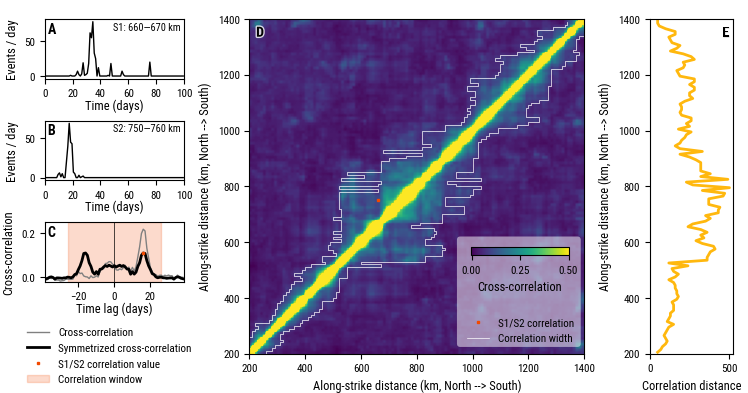

In [66]:
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 10])/2.54)
    gs = fig.add_gridspec(4, 4, width_ratios=[1, 1, 1, .6], height_ratios=[1, 1, 1, .5])

    # Time series
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    for ax in [ax1, ax2]:
        ax.set_ylabel('Events / day')
        ax.set_xlabel('Time (days)', labelpad=0)
        ax.set_xticks(np.arange(0, 6/5*dt, dt/5))
        ax.set_xlim(0, dt)
    ax1.plot(count_time-t0, count1, 'k-', lw=1)
    ax2.plot(count_time-t0, count2, 'k-', lw=1)

    ax1.text(.98, .95, 'S1: {:.0f}—{:.0f} km'.format(x1, x1+dx_bin), transform=ax1.transAxes, fontsize='small', va='top', ha='right')
    ax2.text(.98, .95, 'S2: {:.0f}—{:.0f} km'.format(x2, x2+dx_bin), transform=ax2.transAxes, fontsize='small', va='top', ha='right')

    ax1.text(.02, .95, 'A', transform=ax1.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax2.text(.02, .95, 'B', transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

    # Autocorrelation function
    ax = fig.add_subplot(gs[2, 0])
    ax.set_xlabel('Time lag (days)', labelpad=0)
    ax.set_ylabel('Cross-correlation')

    ax.plot(lag, cc12, ls='-', c='.5', lw=1, label='Cross-correlation')
    ax.plot(lag, (cc12 + cc12[::-1])/2, ls='-', c='k', lw=2, label='Symmetrized cross-correlation')

    in_window = (lag > 0) & (lag < (x2-x1)/v_min)
    ii_max = np.argmax(((cc12 + cc12[::-1])/2)[in_window])
    ax.plot(lag[in_window][ii_max], ((cc12 + cc12[::-1])/2)[in_window][ii_max], 's', c='C1', ms=2, label='S1/S2 correlation value')

    ax.axvspan(-(x2-x1)/v_min, (x2-x1)/v_min, color=to_rgba('C1', .2), zorder=-10, label='Correlation window')
    ax.axvline(0, color='k', lw=.5)

    ax.set_xlim(-1.5*(x2-x1)/v_min, 1.5*(x2-x1)/v_min)
    ax.set_ylim(-0.02, 0.25)

    ax.legend(bbox_to_anchor=(-0.2, -0.6), loc='upper left', framealpha=0, )

    ax.text(.02, .95, 'C', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

    # Matrix
    ax = fig.add_subplot(gs[:, 1:-1])
    ax.set_aspect('equal')
    ax.set_xlabel('Along-strike distance (km, North --> South)')
    ax.set_ylabel('Along-strike distance (km, North --> South)')

    im = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
    ax.plot(x1, x2, 's', c='C1', ms=2, label='S1/S2 correlation')
    ax.step(x_bin_edges[:-1]-left_width, x_bin_edges[:-1], c='w', lw=.5)
    ax.step(x_bin_edges[:-1]+right_width+dx_bin, x_bin_edges[:-1], c='w', lw=.5, label='Correlation width')

    leg = ax.legend(bbox_to_anchor=(1, 0), loc='lower right', framealpha=0)

    cb_ax = plt.axes([0.63, 0.35, 0.13, 0.02])
    cbar = plt.colorbar(im, cax=cb_ax, orientation='horizontal', label='Cross-correlation')
    # for label in cb_ax.get_xticklabels():
    #     label.set(path_effects=[fx.withStroke(linewidth=1.5, foreground=to_rgba('w', .8))])
    # cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=1.5, foreground=to_rgba('w', .8))])
    # cb_ax.xaxis.get_label().set_va('center')

    import matplotlib.patches as mpatches
    box = mpatches.FancyBboxPatch([.62, .02], .37, .33, boxstyle="Round, pad=0, rounding_size=.01", facecolor=to_rgba('w', .5), edgecolor=[0,0,0,0], transform=ax.transAxes)
    ax.add_patch(box)

    ax.text(.02, .98, 'D', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left', path_effects=[fx.withStroke(linewidth=2, foreground=to_rgba('w', .8))])

    # Correlation distance
    ax = fig.add_subplot(gs[:, -1], sharey=ax)
    ax.set_xlabel('Correlation distance')
    ax.set_ylabel('Along-strike distance (km, North --> South)')

    ax.plot(corr_length, x_bin_edges[:-1]+dx_bin/2, 'C2-', lw=2)

    ax.set_xlim(xmin=0)

    ax.text(.95, .98, 'E', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right', path_effects=[fx.withStroke(linewidth=2, foreground=to_rgba('w', .8))])

    plt.subplots_adjust(left=.06, right=.98, top=.95, bottom=.1, wspace=.5, hspace=.8)
    plt.savefig('figures/correlation_distance.pdf', dpi=300)
    plt.savefig('figures/correlation_distance.png', dpi=300)
    plt.show()

## 5.3. <a id='toc5_3_'></a>For the supplements  [&#128285;](#toc0_)

In [68]:
interval = [np.datetime64('2018-01-01'), np.datetime64('2024-06-01')]
trm_in_interval = trm[(trm.date > interval[0]) & (trm.date < interval[1])]
eq_in_interval = eq[(eq.date > interval[0]) & (eq.date < interval[1])]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_48565/3018224870.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('C0', .5), label='Tremor')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_48565/3018224870.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')


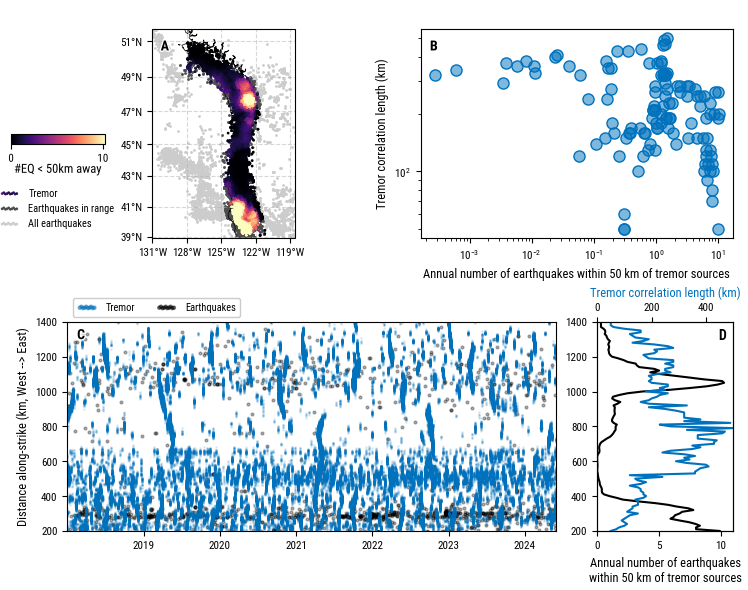

In [82]:
# Plot
import matplotlib.patheffects as fx

with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.09, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=trm.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(trm.lon, trm.lat, c=trm.n_eq_50km, s=1, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm.n_eq_50km, 95), zorder=2, label='Tremor', rasterized=True)
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower right', bbox_to_anchor=(-.2, 0), fontsize='small', framealpha=0, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = -0.18; y_min_ax = 0.45
    w_ax = 0.3; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(chosen_dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.06, 0.95, 'A', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel('Annual number of earthquakes within 50 km of tremor sources')
    ax.set_ylabel('Tremor correlation length (km)')

    ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='C0', mfc=to_rgba('C0', .5))

    # ax.set_xlim(9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, West --> East)')

    ax.plot(trm_in_interval.date, trm_in_interval.xf, 'o', ms=1, color=to_rgba('C0', .1), rasterized=True)
    ax.plot(eq_in_interval.date[eq_in_interval.in50km], eq_in_interval.xf[eq_in_interval.in50km], 'o', ms=2., color=to_rgba('k', .3), zorder=0, rasterized=True)

    ax.set_xlim(trm_in_interval.date.min(), trm_in_interval.date.max())
    ax.set_ylim(200, 1400)

    ax.scatter([], [], s=5, c=to_rgba('C0', .5), label='Tremor')
    ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources')
    ax.set_xlim(0, 11)

    ax.plot(n_close_eq[chosen_dist], x_bin_edges[:-1], c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 500)
    ax_cc.plot(corr_length, x_bin_edges[:-1], 'C0')
    ax_cc.set_xlabel('Tremor correlation length (km)', color='C0')

    ax.text(0.95, 0.97, 'D', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top')
    
    plt.savefig('figures/cascadia_supp.png', dpi=300)
    plt.savefig('figures/cascadia_supp.pdf', dpi=300)
    plt.show()